In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
Gold = pd.read_excel("GoldData.xlsx")

In [3]:
Gold.head()

,Respondent,Subscriber,Income,GoldPurchase
0,1,0,664,26.9
1,2,0,680,7.1
2,3,0,549,21.5
3,4,0,506,19.3
4,5,0,541,16.7


In [4]:
X = Gold.columns

In [5]:
X_features = list( Gold.columns )
X_features.remove( 'Subscriber' )
X_features.remove('Respondent')
X_features

['Income', 'GoldPurchase']

In [6]:
Y = Gold.Subscriber

In [7]:
GoldTarget_names = ['Yes', 'No']

In [8]:
Y = pd.Categorical.from_codes(Gold.Subscriber, GoldTarget_names)

In [9]:
Y

['Yes', 'Yes', 'Yes', 'Yes', 'Yes', ..., 'No', 'No', 'No', 'No', 'No']
Length: 84
Categories (2, object): ['Yes', 'No']

In [10]:
X = pd.DataFrame(Gold, columns=X_features)

In [11]:
X.head()

,Income,GoldPurchase
0,664,26.9
1,680,7.1
2,549,21.5
3,506,19.3
4,541,16.7


In [12]:
df = X.join(pd.Series(Y, name='subscriber'))

In [13]:
df.head()

,Income,GoldPurchase,subscriber
0,664,26.9,Yes
1,680,7.1,Yes
2,549,21.5,Yes
3,506,19.3,Yes
4,541,16.7,Yes


In [14]:
class_feature_means = pd.DataFrame(columns=GoldTarget_names)
for c, rows in df.groupby('subscriber'):
    class_feature_means[c] = rows.mean()
class_feature_means

,Yes,No
Income,660.421053,804.851852
GoldPurchase,24.952632,53.000000


In [15]:
within_class_scatter_matrix = np.zeros((2,2))
for c, rows in df.groupby('subscriber'):
 rows = rows.drop(['subscriber'], axis=1)
    
 s = np.zeros((2,2))
for index, row in rows.iterrows():
        x, mc = row.values.reshape(2,1), class_feature_means[c].values.reshape(2,1)
        
        s += (x - mc).dot((x - mc).T)
    
within_class_scatter_matrix += s

In [16]:
feature_means = df.mean()
between_class_scatter_matrix = np.zeros((2,2))
for c in class_feature_means:    
    n = len(df.loc[df['subscriber'] == c].index)
    
    mc, m = class_feature_means[c].values.reshape(2,1), feature_means.values.reshape(2,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

In [17]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

In [18]:
eigen_vectors

array([[-0.1906,  0.0272],
       [ 0.9817, -0.9996]])

In [19]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

7.581361651207091
1.7763568394002505e-15


In [20]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 1.0000000000000002
Eigenvector 1: 2.3430577792281187e-16


In [20]:
w_matrix = np.hstack((pairs[0][1].reshape(2,1), pairs[1][1].reshape(2,1))).real

In [21]:
X_lda = np.array(X.dot(w_matrix))

In [22]:
le = LabelEncoder()
y = le.fit_transform(df['subscriber'])

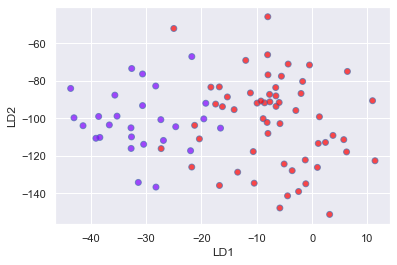

In [23]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
#X_lda = lda.fit_transform(X, y)
X_lda = lda.fit(X,y)

In [39]:
lda.explained_variance_ratio_

array([1.])

In [26]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
X_qda = qda.fit(X, y)

In [32]:
#DEFINE METHOD TO EVALUATE MODEL
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#EVALUATE MODEL
scores = cross_val_score(X_qda, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))

0.9060185185185184


In [34]:
#USE MODEL TO MAKE PREDICTION ON NEW OBSERVATION
new = [600,20.5]
X_qda.predict([new])

array([1])

In [40]:
lda.predict([new])

array([1])

In [41]:
scores_lda = cross_val_score(X_lda, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_lda))

0.9023148148148148
